In [1]:
import time
import hopsworks
import os
from dotenv import load_dotenv
import joblib

# from datetime import datetime, timedelta
import pandas as pd

import hopsworks
import matplotlib.pyplot as plt

from utils import *
import utils


In [2]:
model_version = 4
fng_feature_group_version = 1
solana_feature_group_version = 1
bitcoin_feature_group_version = 1

In [3]:
today = int(time.time())
seconds_in_one_day = 24 * 60 * 60
today

1736022364

In [4]:
load_dotenv()
#os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()
#secrets = secrets_api(project.name)
# This line will fail if you have not registered the CRYPTO_API_KEY as a secret in Hopsworks
#CRYPTO_API_KEY = secrets.get_secret("CRYPTO_API_KEY").value

#CRYPTO_API_KEY = os.getenv("CRYPTO_API_KEY")

2025-01-04 22:26:04,849 INFO: Initializing external client
2025-01-04 22:26:04,849 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-04 22:26:08,811 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160346


In [5]:
fs = project.get_feature_store() 
starting_timestamp = float(today - 40 * seconds_in_one_day)
starting_timestamp


1732566364.0

In [6]:
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=solana_feature_group_version
)

solana_batch_data = solana_feature_group.filter(solana_feature_group.timestamp >= starting_timestamp).read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
solana_batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


,timestamp,open,high,low,close,volume,volume_buy,volume_sell
0,1732579200,233.96,239.68,221.82,230.68,445887.775346,201503.607457,244384.167889
1,1732665600,230.68,245.00,227.66,242.26,265621.873707,161330.187523,104291.686184
2,1732752000,242.26,245.46,233.00,237.59,142466.637324,73142.398338,69324.238987
3,1732838400,237.59,247.04,236.58,243.47,301558.576846,121169.466633,180389.110213
4,1732924800,243.47,245.34,237.56,237.75,173213.101124,81975.271321,91237.829804


In [7]:
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=bitcoin_feature_group_version
)
bitcoin_batch_data = bitcoin_feature_group.filter(bitcoin_feature_group.timestamp >= starting_timestamp).read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
bitcoin_batch_data = bitcoin_batch_data[["timestamp","open"]]
bitcoin_batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


,timestamp,open
0,1732579200,93000.0
1,1732665600,91914.5
2,1732752000,95952.9
3,1732838400,95637.8
4,1732924800,97478.7


In [8]:
fng_feature_group = fs.get_feature_group(
    'f_n_g_index',
    version=fng_feature_group_version
)
fng_batch_data = fng_feature_group.filter(fng_feature_group.timestamp >= starting_timestamp).read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
fng_batch_data['fng_classification'] = fng_batch_data['fng_classification'].map(fng_labels_to_numbers_map)
fng_batch_data.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,fng_value,fng_classification,timestamp
0,79,4,1.732579e+09
1,75,3,1.732666e+09
2,77,4,1.732752e+09
3,78,4,1.732838e+09
4,84,4,1.732925e+09


In [9]:
from tensorflow.keras.models import load_model

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="solana_price_daily_model_10d",
    version=model_version,
)
saved_model_dir = retrieved_model.download()
print(saved_model_dir)
model = load_model(saved_model_dir+'/best_model.keras')
model


/var/folders/rh/xp6gtwpn19s_8lqdxq8sdl0r0000gn/T/b9437687-934a-40ba-82ef-5fa038dbc6f2/solana_price_daily_model_10d/4


<Sequential name=sequential, built=True>

In [10]:
all_data = pd.merge(solana_batch_data, bitcoin_batch_data, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_batch_data, how='inner', on="timestamp")

if "timestamp" in all_data.columns:
    all_data = all_data.drop(columns=['timestamp'])

target_column = 'open_solana'
all_data = utils.move_target_at_the_end(all_data, target_column)
all_data_values = all_data.values[-30:]

all_data.head()

,high,low,close,volume,volume_buy,volume_sell,open_bitcoin,fng_value,fng_classification,open_solana
0,239.68,221.82,230.68,445887.775346,201503.607457,244384.167889,93000.0,79,4,233.96
1,245.00,227.66,242.26,265621.873707,161330.187523,104291.686184,91914.5,75,3,230.68
2,245.46,233.00,237.59,142466.637324,73142.398338,69324.238987,95952.9,77,4,242.26
3,247.04,236.58,243.47,301558.576846,121169.466633,180389.110213,95637.8,78,4,237.59
4,245.34,237.56,237.75,173213.101124,81975.271321,91237.829804,97478.7,84,4,243.47


In [11]:
model_workspace = "solana_price_10d_scalers/" 
scaler_labels = joblib.load(model_workspace+'scaler_labels.pkl')
scaler_features = joblib.load(model_workspace+'scaler_features.pkl')

all_data_values = scaler_features.transform(all_data_values)
X = all_data_values.reshape(1, 30, 10)


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [12]:
all_data.columns

Index(['high', 'low', 'close', 'volume', 'volume_buy', 'volume_sell',
       'open_bitcoin', 'fng_value', 'fng_classification', 'open_solana'],
      dtype='object')

In [13]:
predictions = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [14]:
predictions

array([[0.7558749 , 0.78590834, 0.764528  , 0.75248384, 0.7892312 ,
        0.73513407, 0.737531  , 0.7450325 , 0.7272974 , 0.7641749 ]],
      dtype=float32)

In [15]:
predictions_unscaled =  scaler_labels.inverse_transform(predictions)
predictions_unscaled


array([[197.87308, 205.35262, 200.02806, 197.02858, 206.18015, 192.7078 ,
        193.30473, 195.1729 , 190.75616, 199.94012]], dtype=float32)

In [16]:

timestamps = [today + (i+1) * seconds_in_one_day for i in range(len(predictions[0]))]

In [17]:
monitor_fg = fs.get_or_create_feature_group(
    name='solana_predictions',
    description='Solana_predictions',
    version=1,
    primary_key=['timestamp']
)

In [18]:
result = pd.DataFrame(columns=['timestamp', "open_solana"])
result["timestamp"]=timestamps
result["open_solana"]=predictions_unscaled[0]
result

,timestamp,open_solana
0,1736108764,197.873077
1,1736195164,205.352615
2,1736281564,200.028061
3,1736367964,197.028580
4,1736454364,206.180145
5,1736540764,192.707794
6,1736627164,193.304733
7,1736713564,195.172897
8,1736799964,190.756165
9,1736886364,199.940125


In [19]:
result['date'] = pd.to_datetime(result['timestamp'], unit='s')
result['date'] = result['date'].dt.normalize()
result= result.sort_values(by=['date'])

# result.drop(columns=["timestamp"], inplace=True)

result

,timestamp,open_solana,date
0,1736108764,197.873077,2025-01-05
1,1736195164,205.352615,2025-01-06
2,1736281564,200.028061,2025-01-07
3,1736367964,197.028580,2025-01-08
4,1736454364,206.180145,2025-01-09
5,1736540764,192.707794,2025-01-10
6,1736627164,193.304733,2025-01-11
7,1736713564,195.172897,2025-01-12
8,1736799964,190.756165,2025-01-13
9,1736886364,199.940125,2025-01-14


In [20]:
#this is plane and we may have duplicates
#monitor_fg.insert(result)

In [21]:
#this insert prevents duplicates
monitor_fg.insert(
    result,
    # overwrite=False,  # Do not overwrite all data
    operation="upsert",  # Use upsert to handle duplicates based on the primary key
    #storage=None  # Write to both online and offline storage
)

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: solana_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1160346/jobs/named/solana_predictions_1_offline_fg_materialization/executions


(Job('solana_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [22]:

import numpy as np

import time
import hopsworks
import os
from dotenv import load_dotenv
import joblib
from datetime import datetime, timedelta, date
import pandas as pd

import hopsworks
import matplotlib.pyplot as plt

from utils import *
import utils
from functools import reduce



In [23]:
solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=solana_feature_group_version
)

solana_actual_df = solana_feature_group.select(["timestamp","open"]).read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


In [24]:
solana_actual_df['date'] = pd.to_datetime(solana_actual_df['timestamp'], unit='s')
solana_actual_df['date'] = pd.to_datetime(solana_actual_df['date'], errors='coerce')

solana_actual_df['date'] = solana_actual_df['date'].dt.normalize()
solana_actual_df['date'] = solana_actual_df['date'].dt.tz_localize(None)
solana_actual_df.drop(columns=["timestamp"], inplace=True)
solana_actual_df.rename(columns={'open': 'solana_open_actual'}, inplace=True)
solana_actual_df = solana_actual_df.sort_values(by='date')


solana_actual_df

,solana_open_actual,date
986,40.23,2021-06-17
829,39.13,2021-06-18
48,36.62,2021-06-19
1246,35.45,2021-06-20
1194,35.28,2021-06-21
...,...,...
1295,191.06,2024-12-31
1293,188.95,2025-01-01
1288,193.82,2025-01-02
1290,208.00,2025-01-03


In [25]:
solana_pred_df=result[["date","open_solana"]]

solana_pred_df['date'] = solana_pred_df['date'].dt.tz_localize(None)
solana_pred_df.rename(columns={'open_solana': 'solana_open_pred'}, inplace=True)
solana_pred_df = solana_pred_df.sort_values(by='date')

solana_pred_df

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,solana_open_pred
0,2025-01-05,197.873077
1,2025-01-06,205.352615
2,2025-01-07,200.028061
3,2025-01-08,197.028580
4,2025-01-09,206.180145
5,2025-01-10,192.707794
6,2025-01-11,193.304733
7,2025-01-12,195.172897
8,2025-01-13,190.756165
9,2025-01-14,199.940125


<module 'matplotlib.pyplot' from '/Users/michailroussos/Desktop/MSc-courses/2024-2025_P2/Saclable Machine Learning and Deep Learning (ID2223)/Assignments/final project/Scalable Final Project/ID2223-final-project/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

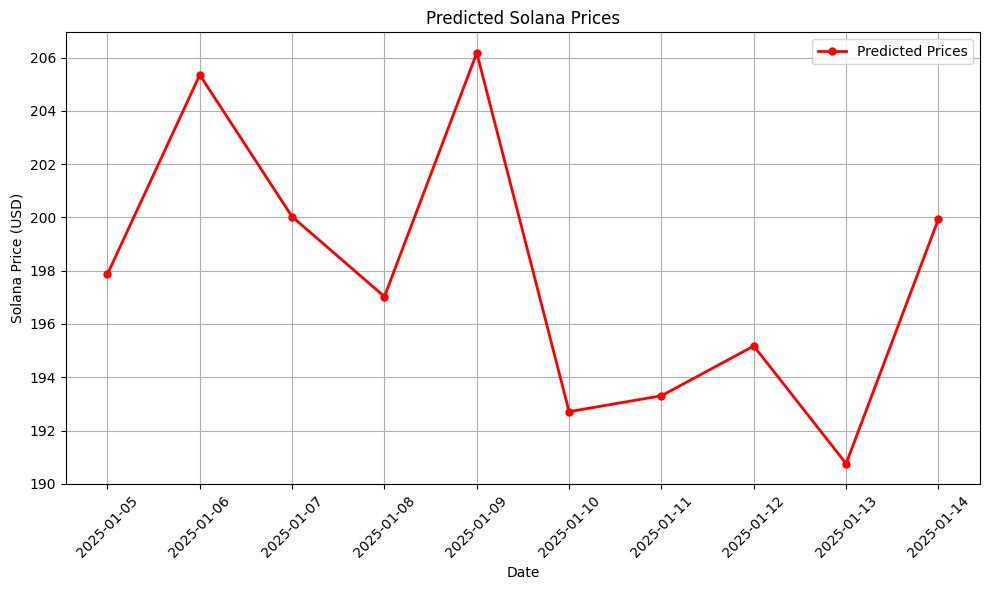

In [26]:
file_path='img/solana_predictions_plot.png'

plot_solana_predictions(solana_pred_df, file_path) 

In [27]:

solana_actual_df['date'] = pd.to_datetime(solana_actual_df['date'], errors='coerce')

solana_actual_df['date'] = solana_actual_df['date'].dt.normalize()
solana_actual_df['date'] = solana_actual_df['date'].dt.tz_localize(None)

solana_pred_df['date'] = pd.to_datetime(solana_pred_df['date'], errors='coerce')

solana_pred_df['date'] = solana_pred_df['date'].dt.normalize()
solana_pred_df['date'] = solana_pred_df['date'].dt.tz_localize(None)

In [28]:
# Merge the two df on date
pred_actual_join = solana_pred_df.merge(solana_actual_df, left_on='date', right_on='date')

# Show the results
pred_actual_join

,date,solana_open_pred,solana_open_actual


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

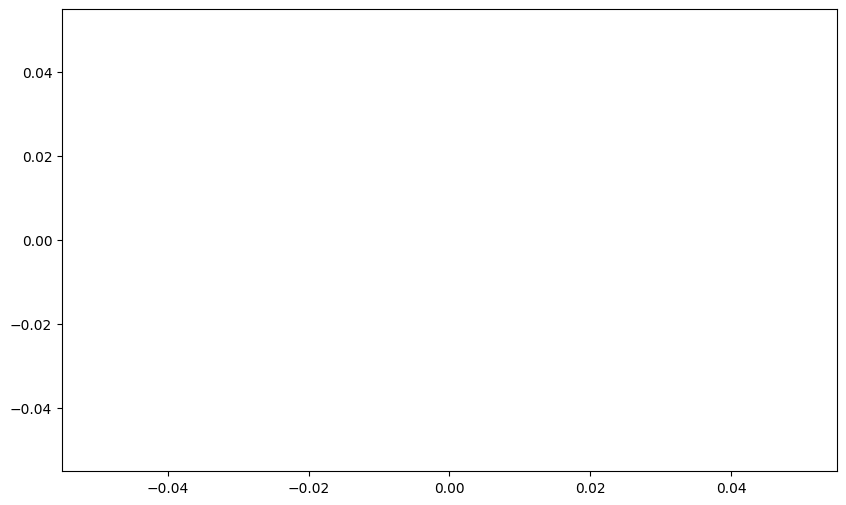

In [29]:
file_path='img/solana_actual_vs_predictions_plot.png'
#if the df is NOT empty, plot the data
if not pred_actual_join.empty:
    print('No data to plot')
    confidence_upper = [p + 1 for p in pred_actual_join['solana_open_pred']]
    confidence_lower = [p - 1 for p in pred_actual_join['solana_open_pred']]
    plot_solana_actual_vs_predictions(pred_actual_join, confidence_lower, confidence_upper, file_path)


In [30]:
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=bitcoin_feature_group_version
)

# Read the data from the feature group
btc_df = bitcoin_feature_group.select(["timestamp","open"]).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 


In [31]:
btc_df['date'] = pd.to_datetime(btc_df['timestamp'], unit='s')
btc_df['date'] = pd.to_datetime(btc_df['date'], errors='coerce')

btc_df['date'] = btc_df['date'].dt.normalize()
btc_df['date'] = btc_df['date'].dt.tz_localize(None)
btc_df.drop(columns=["timestamp"], inplace=True)
btc_df.rename(columns={'open': 'btc_open'}, inplace=True)
#btc_df = btc_df.sort_values(by='date')


btc_df

,btc_open,date
0,27589.7,2023-04-24
1,40095.8,2022-02-20
2,24313.6,2022-08-15
3,69317.0,2024-06-08
4,22827.9,2022-08-04
...,...,...
1307,98111.1,2025-01-04
1308,93370.9,2025-01-01
1309,98647.2,2024-12-25
1310,99310.8,2024-12-26


In [32]:
fng_feature_group = fs.get_feature_group(
    name='f_n_g_index', 
    version=fng_feature_group_version
)
fng_df = fng_feature_group.select(["timestamp","fng_value"]).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


In [33]:
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], unit='s')
fng_df['date'] = pd.to_datetime(fng_df['date'], errors='coerce')

fng_df['date'] = fng_df['date'].dt.normalize()
fng_df['date'] = fng_df['date'].dt.tz_localize(None)
fng_df.drop(columns=["timestamp"], inplace=True)
#fng_df.rename(columns={'value': 'fng_value'}, inplace=True)
#fng_df = fng_df.sort_values(by='date')


fng_df

,fng_value,date
0,74,2024-06-15
1,77,2024-03-18
2,43,2019-02-15
3,68,2024-07-26
4,30,2022-08-04
...,...,...
2521,50,2020-05-18
2522,79,2024-02-13
2523,27,2022-02-25
2524,28,2018-11-19


In [34]:

# List of DataFrames to merge
dfs = [btc_df, solana_actual_df, fng_df]

# Merge all DataFrames on 'date'
sln_btc_fng_join = reduce(lambda left, right: left.merge(right, on='date', how='inner'), dfs)
sln_btc_fng_join = sln_btc_fng_join.sort_values(by='date')

sln_btc_fng_join

,btc_open,date,solana_open_actual,fng_value
986,38337.1,2021-06-17,40.23,26
829,38078.2,2021-06-18,39.13,25
48,35824.0,2021-06-19,36.62,23
1245,35490.5,2021-06-20,35.45,21
1193,35595.0,2021-06-21,35.28,23
...,...,...,...,...
1296,92611.3,2024-12-31,191.06,64
1293,93370.9,2025-01-01,188.95,66
1287,94380.8,2025-01-02,193.82,70
1285,96805.2,2025-01-03,208.00,74


<module 'matplotlib.pyplot' from '/Users/michailroussos/Desktop/MSc-courses/2024-2025_P2/Saclable Machine Learning and Deep Learning (ID2223)/Assignments/final project/Scalable Final Project/ID2223-final-project/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

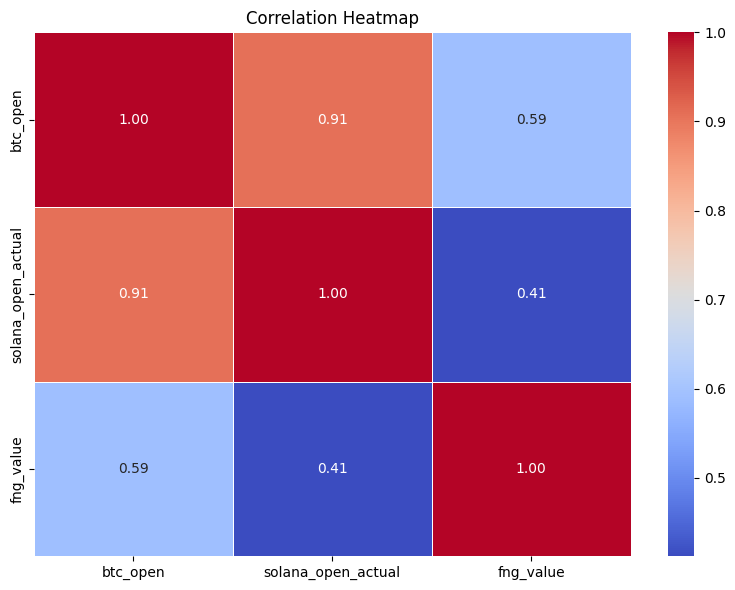

In [35]:
file_path='img/sln_btc_fng_heatmap.png'

plot_correlation_heatmap(sln_btc_fng_join,file_path)

In [36]:
# List of DataFrames to merge
dfs = [btc_df, solana_actual_df,solana_pred_df, fng_df]

# Merge all DataFrames on 'date'
trend_join = reduce(lambda left, right: left.merge(right, on='date', how='inner'), dfs)
trend_join = trend_join.sort_values(by='date')

trend_join.columns

Index(['btc_open', 'solana_open_actual', 'solana_open_pred', 'fng_value',
       'date'],
      dtype='object')

<module 'matplotlib.pyplot' from '/Users/michailroussos/Desktop/MSc-courses/2024-2025_P2/Saclable Machine Learning and Deep Learning (ID2223)/Assignments/final project/Scalable Final Project/ID2223-final-project/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

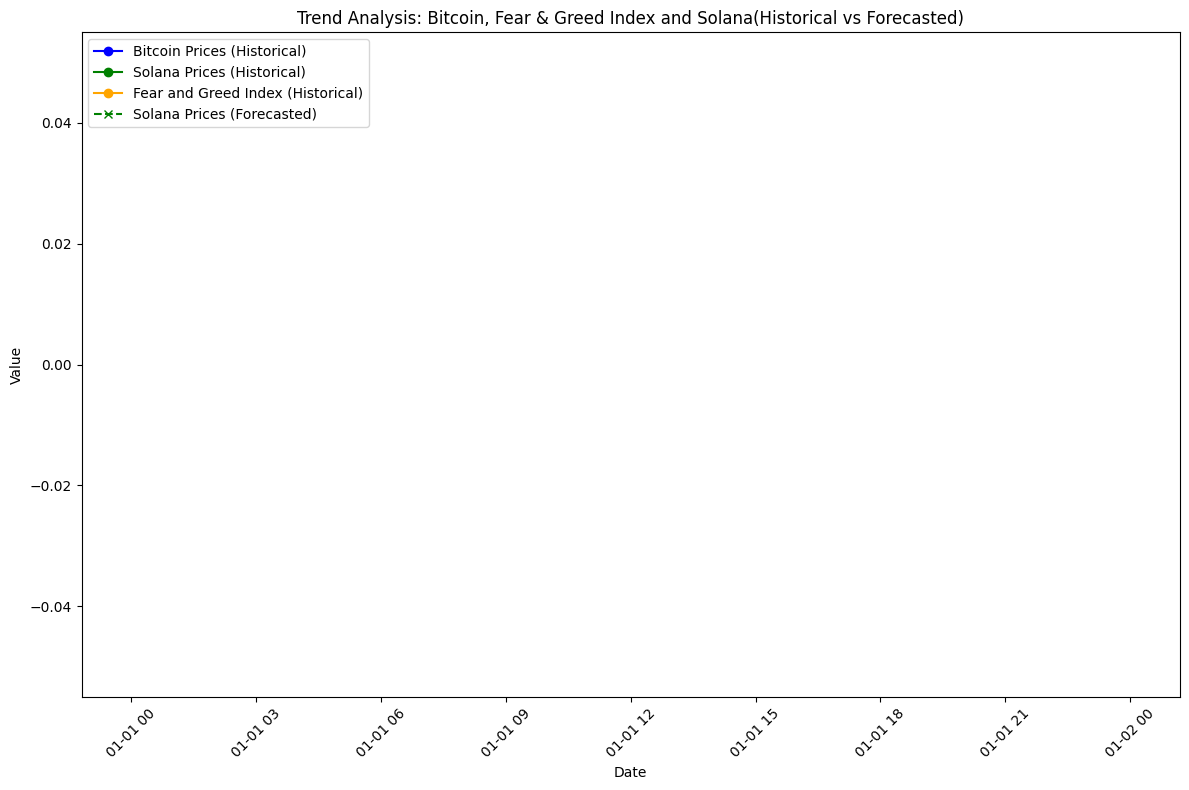

In [37]:
file_path='img/trend_analisis.png'

plot_trend_analysis(trend_join,file_path)